Load model from provided .xml file. Import required packages

In [3]:
import cobra.test
import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt

from S3A_test import test_results

model=cobra.io.read_sbml_model("420_model.xml")

from cobra import Reaction, Metabolite

## Figure S3A

Classify each double mutant and carbon source as 0 (no growth), 1 (growth only with RuBISCO flux), and 2 (growth with or without RuBISCO flux). These values should be entered in a list (example below) in the order shown in the Excel document (you should have 3 nested loops: KO, KO, carbon source).

### Dictonaries for going between paper and model

In [4]:
# Carbon sources
source_rename_map = {
    "glu": "g6p",
    "fru": "f6p",
    "gnt": "6pgc",
    "rib": "r5p",
    "pyr": "pyr",
    "xyl": "xu5p__D",
    "2pg": "2pg",
    "ace": "ac",
    "gly": "dhap"
}
source_metabolite_rename_map, source_rxn_rename_map = ({}, {})
for (key, value) in source_rename_map.items():
    source_metabolite_rename_map[key] = value + "_c"
    source_rxn_rename_map[key] = "EX_" + value + "_c"
sources = list(source_rename_map.keys())

# Reactions
reaction_rename_map = {    
    "PTS": ["FRUpts2", "GLCpts"],
    "PGI": ["PGI"],
    "PFK": ["PFK"],
    "FBP": ["FBP"],
    "FBA": ["FBA"],
    "TPI": ["TPI"],
    "GAPD": ["GAPD"],
    "GPM": ["PGM"],
    "ENO": ["ENO"],
    "PYK": ["PYK"],
    "PPS": ["PPS"],
    "PDH": ["PDH"],
    "PFL": ["PFL"],
    "ZWF": ["G6PDH2r"],
    "GND": ["GND"],
    "EDA": ["EDA"],
    "RPE": ["RPE"],
    "RPI": ["RPI"],
    "TKT": ["TKT1", "TKT2"],
    "TAL": ["TALA"],
    "PPC": ["PPC"],
    "PPCK": ["PPCK"],
    "CS": ["CS"],
    "ACONT": ["ACONTa", "ACONTb"],
    "ALCD2x": ["ALCD2x"],
    "ACALD": ["ACALD"],
}

rxns = list(reaction_rename_map.keys())

### Model search script

In [16]:
search = "glu"
for m in model.metabolites:
    if search.lower() in m.id.lower():
        print("{:<10} : {}".format(m.id, m.name))
        
print()
for r in model.reactions:
    if search.lower() in r.reaction.lower():
        print("{:} :\n\t{}".format(r.id, r.reaction))


glu__L_c   : L-Glutamate
glu__L_e   : L-Glutamate

BIOMASS_Ecoli_core_w_GAM :
	1.496 3pg_c + 3.7478 accoa_c + 59.81 atp_c + 0.361 e4p_c + 0.0709 f6p_c + 0.129 g3p_c + 0.205 g6p_c + 0.2557 gln__L_c + 4.9414 glu__L_c + 59.81 h2o_c + 3.547 nad_c + 13.0279 nadph_c + 1.7867 oaa_c + 0.5191 pep_c + 2.8328 pyr_c + 0.8977 r5p_c --> 59.81 adp_c + 4.1182 akg_c + 3.7478 coa_c + 59.81 h_c + 3.547 nadh_c + 13.0279 nadp_c + 59.81 pi_c
EX_glu__L_e :
	glu__L_e --> 
GLNS :
	atp_c + glu__L_c + nh4_c --> adp_c + gln__L_c + h_c + pi_c
GLUDy :
	glu__L_c + h2o_c + nadp_c <=> akg_c + h_c + nadph_c + nh4_c
GLUN :
	gln__L_c + h2o_c --> glu__L_c + nh4_c
GLUSy :
	akg_c + gln__L_c + h_c + nadph_c --> 2.0 glu__L_c + nadp_c
GLUt2r :
	glu__L_e + h_e <=> glu__L_c + h_c


### Validating that all dictionary values line up with model objects

In [6]:
# Checking
print("All diffs should be zero.")
count = 0
for m in model.metabolites:
    if m.id in source_metabolite_rename_map.values():
        count += 1
        # print("{:<10} : {}".format(m.id, m.name));
        
print("Diff: {:d}\n".format(len(source_metabolite_rename_map) - count))

count = 0
for r in model.reactions:
    if r.id in source_rxn_rename_map.values():
        count += 1
        # print("{:<10} : {}".format(r.id, r.name));
        
print("Diff: {:d}\n".format(len(source_rxn_rename_map) - count))

count = 0
vals = sum(list(reaction_rename_map.values()), [])
length = len(vals)
for r in model.reactions:
    if r.id in vals:
        count += 1
        del vals[vals.index(r.id)]
        # print("{:<10} : {}".format(r.id, r.name))
        
print("Diff: {:d}".format(length - count))

All diffs should be zero.
Diff: 0

Diff: 0

Diff: 0


### Adding PRK and RuBisCO catalyzed reactions

In [7]:
# Creating reactions
prk_rxn = Reaction("PRK")
rubisco_rxn = Reaction("RUBISCO")

# creating new metabolite ribulose-1,5-bisphosphate
rdp_c = Metabolite(
    "rdp_c",
    formula="C5H12O11P2",
    name="ribulose 1,5-bisphosphate",
    compartment="c")

# putting reactions and metabolites into model
model.add_metabolites(rdp_c)
model.add_reactions([prk_rxn, rubisco_rxn])

# setting up reactions
# PRK: Ribulose 5-phosphate + ATP -> Ribulose 1,5-bisphosphate + ADP
prk_rxn.name = "phosphoribulose phosphorylation"
prk_rxn.add_metabolites({
    "ru5p__D_c": -1.0,
    "atp_c": -1.0,
    "rdp_c": +1.0,
    "adp_c": +1.0
})

# RuBISCO: Ribulose 1,5-bisphosphate + H2O + CO2 -> 2 (glycerate 3-phosphate) + 3H
rubisco_rxn.name = "bisphosphoribulose cleavage to phosphoglycerate"
rubisco_rxn.add_metabolites({
    "rdp_c": -1.0,
    "h2o_c": -1.0,
    "co2_c": -1.0,
    "h_c": +3.0,
    "3pg_c": +2.0
})

### Modifying model for no carbon source uptake

In [8]:
r = model.reactions.get_by_id("EX_glc__D_e")
r.knock_out()

lower_bound_cache = {}

for key in sources:
    s_id = source_rxn_rename_map[key]
    r = model.reactions.get_by_id(s_id)
    r.lower_bound = 0
    
    m_id = source_metabolite_rename_map[key]
    met = model.metabolites.get_by_id(m_id)
    nC = met.elements['C']
    lower_bound_cache[key] = -50.0 / float(nC)

### Deletion and optimization loop for heat map figure

In [9]:
print("Beginning Optimizations...")

counter = 0
plotting_cache = []
tol = 0.0000001

for rxn1 in rxns:
    for rxn2 in rxns:
        for s_key in sources:
            with model as m:                 
                s_id = source_rxn_rename_map[s_key]
                r = m.reactions.get_by_id(s_id)
                r.lower_bound = lower_bound_cache[s_key]
                
                rxn_list = reaction_rename_map[rxn1] + reaction_rename_map[rxn2]
                for r_name in rxn_list:
                    r = m.reactions.get_by_id(r_name)
                    r.knock_out()
                    
                soln = m.optimize()
                obj_val = soln.objective_value
                
                if obj_val < tol:
                    plotting_cache.append(0)
                else:
                    r = m.reactions.get_by_id("RUBISCO")
                    r.knock_out()
                    r = m.reactions.get_by_id("PRK")
                    r.knock_out()
                    soln = m.optimize()
                    obj_val = soln.objective_value
                    if obj_val < tol:
                        plotting_cache.append(1)
                    else:
                        plotting_cache.append(2)
                        
                counter += 1
                if True and (counter % 1000) == 0:
                    print("#{:5d} - BMACCUM: {:8.3f}".format(counter, obj_val))
                    
print("Done!")

Beginning Optimizations...
# 1000 - BMACCUM:    0.000
# 2000 - BMACCUM:    0.723
# 3000 - BMACCUM:    0.764
# 4000 - BMACCUM:    0.691
# 5000 - BMACCUM:    0.571
# 6000 - BMACCUM:    0.827
Done!


### Testing Results and Plotting Figure 

All entries are correct


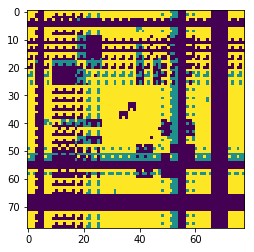

In [10]:
test_results(plotting_cache)

## Figure S3B

simulate 50 values of the biomass accumulation rate

In [11]:
print("Beginning Optimizations for Figure S3B")

bm_id = "BIOMASS_Ecoli_core_w_GAM"

# (Biomass Vector, Min Vector, Max Vector)
rbsc_flux_cache = np.zeros([4, 3, 50])

conditions = ((["PFK", "ZWF"], "pyr"),
              (["PFK", "ZWF"], "xyl"),
              (["GPM", "ZWF"], "pyr"),
              (["GPM", "ZWF"], "xyl"))

for i_cond, (rxn_keys, source_key) in enumerate(conditions):
    rxns = [reaction_rename_map[k] for k in rxn_keys]
    rxns = sum(rxns, [])
    
    s_id = source_rxn_rename_map[source_key]
    
    with model as m:
        r = m.reactions.get_by_id(s_id)
        r.lower_bound = lower_bound_cache[source_key]
        
        for r_id in rxns:
            r = m.reactions.get_by_id(r_id)
            r.knock_out()
            
        soln = m.optimize()
        max_biomass = soln.objective_value
        bm_values = np.linspace(1e-5, max_biomass - 1e-5, 50)
        rbsc_flux_cache[i_cond][0] = bm_values
        
        m.objective = "RUBISCO"
        if max_biomass > 1e-3:
            for i_col, obj_dir in [(1, "max"), (2, "min")]:
                m.objective_direction = obj_dir
                for i_row, bm_val in enumerate(bm_values):
                    m.reactions.get_by_id(bm_id).lower_bound = bm_val
                    soln = m.optimize()
                    rbsc_flux_cache[i_cond, i_col, i_row] = soln.objective_value

print("Done!")


Beginning Optimizations for Figure S3B
Done!


### Plotting Figure S3B data

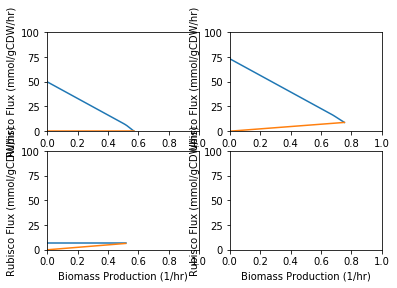

In [12]:
for i_cond, data in enumerate(rbsc_flux_cache):
    x = data[0]
    y_max = data[1]
    y_min = data[2]
    plt.subplot(221 + i_cond)
    plt.plot(x, y_max)
    plt.plot(x, y_min)
    plt.xlim([0, 1])
    plt.ylim([0, 100])
    plt.xlabel("Biomass Production (1/hr)")
    plt.ylabel("Rubisco Flux (mmol/gCDW/hr)")

plt.show()


### Figure S5A

Important note from figure caption:
* 10 mmol gCDW-1 h-1 for xylose, 
* 16.7 for pyruvate and 
* 6.2 mmol gCDW-1 h-1 for each of the two carbon sources when combined.

In [22]:
print("Beginning Optimizations for Figure S5A")

# along dim 2: (Biomass Vector, Min Vector, Max Vector)
rbsc_flux_cache_2 = np.zeros([3, 3, 50])

conditions = ((["PFK", "ZWF", "GPM"], ["xyl"]),
              (["PFK", "ZWF", "GPM"], ["xyl", "pyr"]),
              (["PFK", "ZWF", "GPM"], ["pyr"]))

xyl_pyr_lower_bound = 1.0/(1.0/lower_bound_cache["xyl"] 
                           + 1.0/lower_bound_cache["pyr"])
rates = [
    lower_bound_cache["xyl"],
    xyl_pyr_lower_bound, 
    lower_bound_cache["pyr"]
];

for i_cond, (rxn_keys, source_keys) in enumerate(conditions):
    rxns = [reaction_rename_map[k] for k in rxn_keys]
    rxns = sum(rxns, [])
    
    with model as m:
        for sk in source_keys:
            s_id = source_rxn_rename_map[sk]
            r = m.reactions.get_by_id(s_id)
            r.lower_bound = rates[i_cond]

        
        for r_id in rxns:
            r = m.reactions.get_by_id(r_id)
            r.knock_out()
            
        soln = m.optimize()
        max_biomass = soln.objective_value
        bm_values = np.linspace(1e-5, max_biomass - 1e-5, 50)
        rbsc_flux_cache_2[i_cond][0] = bm_values
        
        m.objective = "RUBISCO"
        if max_biomass > 1e-3:
            for i_col, obj_dir in [(1, "max"), (2, "min")]:
                m.objective_direction = obj_dir
                for i_row, bm_val in enumerate(bm_values):
                    m.reactions.get_by_id(bm_id).lower_bound = bm_val
                    soln = m.optimize()
                    rbsc_flux_cache_2[i_cond, i_col, i_row] = soln.objective_value

print("Done!")

Beginning Optimizations for Figure S5A
Done!


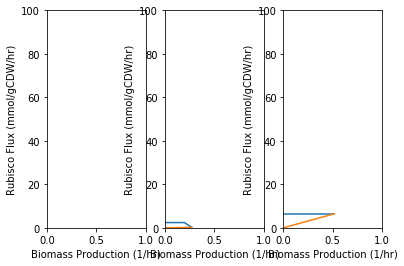

In [23]:
for i_cond, data in enumerate(rbsc_flux_cache_2):
    x = data[0]
    y_max = data[1]
    y_min = data[2]
    plt.subplot(131 + i_cond)
    plt.plot(x, y_max)
    plt.plot(x, y_min)
    plt.xlim([0, 1])
    plt.ylim([0, 100])
    plt.xlabel("Biomass Production (1/hr)")
    plt.ylabel("Rubisco Flux (mmol/gCDW/hr)")

plt.show()